# PygorPro ***RAPID***

Generates all the plots - unscaled and scaled, and CC for each day!

Currently plots raw data - boxcar filtering from from analysis notebook can be integrated for smoothing.

## Setup with all funcs

In [7]:
#import everything and set dpi here

from igor2.binarywave import load as loadibw
import os

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 #set dpi of figs for entire notebook

from tqdm import tqdm

# protocolID: function that identifies protocol based on number of sweeps.

def protocolID(wavedata, twop = False, tr20 = False):

    """
    Function that Identifies protocols based on number of sweeps,
    1  = 20 Train
    3  = Test Pulse (single)
    10 = Paired Pulse Protocol
    
    Parameters:
    
    wavedata  : pandas dataframe 
    
    Optional Parameters:
    
    twop      : if TRUE, returns only two_pulse list     DEFAULT: False
    tr20      : if TRUE, returns only train_20p list     DEFAULT: False
    
    Returns:
    
    two_pulse  [list]
    train_20p  [list]
    one_pulse  [list]
    unassigned [list]

    """
    if type(waves) == dict:
        wavlst = list(waves.keys())
    else:
        wavlst = list(wavedata.columns)

    train_20p = []
    one_pulse = []
    two_pulse = []
    unassigned = []
    dump = []

    # loop through the thingy
    for ele in wavlst:

        if len(dump) == 0: # if dump is empty, just add the element
            dump += [ele]

        else: #if dump is not empty, check if it's from the same series as previous

            if ele[2:4] == dump[-1][2:4]: #if same as previous, add to dump
                dump += [ele]

            elif len(dump) == 20: #if not same as previous and dump has 10, put it to two pulse
                two_pulse += [dump]
                dump = [ele]

            elif len(dump) == 6: # if not same as previous and not 10, but 3, one pulse
                one_pulse += [dump]
                dump = [ele]

            elif len(dump) == 2: # if not same as previous and not 10 or 3, train 20 pulses
                train_20p += [dump]
                dump = [ele]

            else: # if none of the above, put to unassigned
                unassigned += [dump]
                dump = [ele]

    # do something about sweeps remaining in dump at the end of the for loop

    if len(dump) == 0: #if same as previous, add to dump
        dump = []       
    elif len(dump) == 20: #if not same as previous and dump has 10, put it to two pulse
        two_pulse += [dump]
        dump = []      
    elif len(dump) == 6: # if not same as previous and not 10, but 3, one pulse
        one_pulse += [dump]
        dump = [] 
    elif len(dump) == 2: # if not same as previous and not 10 or 3, train 20 pulses
        train_20p += [dump]
        dump = []       
    else: # if none of the above, put to unassigned
        unassigned += [dump]
        dump = []
    
    if twop:
        return two_pulse
    elif tr20:
        return train_20p
    else:
        return two_pulse, one_pulse, train_20p, unassigned
    
#WAVEPLOT: function to plot stim and rec paired waves together

def waveplot(stimID, recID, wavedata, paramdata = pd.DataFrame(), stim_c = 'b', stim_t = 1, stim_a = 1, rec_c = 'r', rec_t = 1, rec_a = 1,
             stim_text = "", rec_text = "", Rs = 0, Cs = 0, holding = 0,
              hratio = [1, 4], dims = (10,4), rec_ylim = (), freq = 50, autoscale = [0,0]):
    
    """
    Function that plots stim and recorded waves together.
    Plotted in Seaborn default theme.
    
    Parameters:
    
    stimID    : expects wave ID
    recID     : expects wave ID
    wavedata  : expects dataframe
        
    Optional Parameters:
    
    paramdata : expects dataframe, adds Rs, Cs and holding   DEFAULT: pd.DataFrame()
    
    > stim aesthetics
    stim_c    : color for stim wave and text                 DEFAULT:'b'
    stim_t    : line thickness                               DEFAULT: 1
    stim_a    : stim alpha                                   DEFAULT: 1
    
    > rec aesthetics
    rec_c     : color for rec wave and text                  DEFAULT:'r'
    rec_t     : line thickness                               DEFAULT: 1
    rec_a     : stim alpha                                   DEFAULT: 1
    
    > stim and rec text
    stim_text : text in stim plot
    rec_text  : additional text in stim plot in new line AFTER Rs, Cslow and holding
    Rs        : Rs value
    Cs        : Cslow value
    holding   : holding voltage
    
    > figure aesthetics
    hratio    : ratio of sizes of the stim and rec           DEFAULT: [1,5]
    dims      : dimensions of the plot in inches             DEFAULT: (2,20)
    rec_ylim  : tuple for scaling plot
    freq      : sampling frequency in KHz or samples/ms      DEFAULT: 50
    
    autoscale : scales plot [-[0]prestim:+[1] poststim] ms!  DEFAULT: [0,0]
 
    """
    
    # get waves from dataframe
    
    stim = wavedata[stimID].dropna()
    rec  = wavedata[recID].dropna()
    
    # if paramdata is provided
    if paramdata.empty == False:
        holding = paramdata.loc[recID][0]
        Cs      = paramdata.loc[recID][1][:-1]
        Rs      = paramdata.loc[recID][2][:-1]
        
    
    time = 0.001*np.arange(0,stim.shape[0]+1)/freq #in seconds, can add if statement for ms later
    
    #scaling routine
    
    start = 0 #default minimum
    end = time.shape[0]-1 #default maximum
    
    if autoscale != [0,0]:
        stim_locs = []
        for i in enumerate(stim):
            i = i[0]
            if i == 0:
                continue
            if stim[i-1] < 1 and stim[i] > 1:
                stim_locs += [i]
                
        start = stim_locs[0] - freq*autoscale[0] #given milliseconds prior to first stim
        end = stim_locs[-1] + freq*autoscale[1]  #given milliseconds post last stim (from start of last stim)
    
    sns.set_theme()
    plt.subplots(2,1,gridspec_kw={'height_ratios': hratio}) #ratio of stim and rec plot sizes
    plt.subplots_adjust(hspace=0) #squeezes plots together
    
    #build rec text label
    if rec_text:
        rec_text = "\n"+rec_text
    if Cs != 0:
        rec_text = "\n$C_{slow}$ "+str(Cs)+"pF"+rec_text
    if Rs != 0:
        rec_text = "\n$R_{s}$ "+str(Rs)+"MOhm"+rec_text
    if holding != 0:
        rec_text = str(holding)+" mV"+rec_text
        
    rec_y = np.min(rec*1e9) # because yloc for rec_text will change if ylim is updated
    

    #plot stim
    plt.subplot(2,1,1)
    plt.plot(time[start:end], stim[start:end], color = stim_c, linewidth = stim_t, alpha = stim_a)
    if stim_text:
        plt.text(time[end],np.max(stim),stim_text, horizontalalignment='right', verticalalignment='top', color = stim_c)
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])
    plt.ylim(-0.2,10)
    
    #plot recorded channel
    plt.subplot(2,1,2)
    plt.plot(time[start:end], rec[start:end]*1e9, color = rec_c, linewidth = rec_t, alpha = rec_a)
    plt.ylabel("nA")
    plt.xlabel("s")
    #plt.gca().set_xticks([])
    if rec_ylim:
        plt.ylim(rec_ylim)
        rec_y = rec_ylim[0] # update yloc if ylim present
    if rec_text:
        plt.text(time[end],rec_y,rec_text, horizontalalignment='right', verticalalignment='bottom', color = rec_c)
        
    plt.gcf().set_size_inches(dims) #sets dimensions of the plot in inches, change dpi across notebook!

# AVGPLOT: Plot a series of sweeps along with an average trace

def avgplot(series, wavedata, paramdata = pd.DataFrame(), theme = False, 
            stim_c = 'b', stim_t = 1, stim_a = 1, rec_c = 'r', rec_t = 1, rec_a = 0.5, avg_c = "black", avg_t = 1, avg_a = 1,
             stim_text = "", rec_text = "", Rs = 0, Cs = 0, holding = 0,
              hratio = [1, 4], dims = (10,4), rec_ylim = (-0.5,0.05), freq = 50, autoscale = [0,0]):
    
    """
    Function that plots an entire series, with an average trace.
    Plotted in Seaborn default theme.
    
    Parameters:
    
    series    : expects list of waves, stim and rec sequence
    wavedata  : expects pandas dataframe of all the wavedata, wave IDs correspond to columns.
    
    Optional Parameters:
    
    paramdata : expects dataframe, adds Rs and Cs values     DEFAULT: pd.DataFrame()
    theme     : Changes sns.set_theme(style)                 DEFAULT: False
    
    stim aesthetics
    stim_c    : color for stim wave and text                 DEFAULT:'b'
    stim_t    : line thickness                               DEFAULT: 1
    stim_a    : stim alpha                                   DEFAULT: 1
    
    rec aesthetics
    rec_c     : color for rec wave and text                  DEFAULT:'r'
    rec_t     : line thickness                               DEFAULT: 1
    rec_a     : rec alpha                                    DEFAULT: 0.4
    
    avg aesthetics
    avg_c     : color for rec wave and text                  DEFAULT:'black'
    avg_t     : line thickness                               DEFAULT: 1
    avg_a     : avg  alpha                                   DEFAULT: 1
    
    stim and rec text
    stim_text : text in stim plot
    rec_text  : additional text in stim plot in new line AFTER Rs, Cslow and holding
    Rs        : Rs value
    Cs        : Cslow value
    holding   : holding voltage
    
    figure aesthetics
    hratio    : ratio of sizes of the stim and rec           DEFAULT: [1,5]
    dims      : dimensions of the plot in inches             DEFAULT: (2,20)
    rec_ylim  : tuple for scaling plot
    freq      : sampling frequency in KHz or samples/ms      DEFAULT: 50
    
    autoscale : scales plot [-[0]prestim:+[1] poststim] ms!  DEFAULT: [0,0]

    """
    
     
    # find stim waves
    stims = series[::2]
    stimdf = wavedata[stims].dropna()
    
    # find rec waves
    recs = series[1::2]
    recdf = wavedata[recs].dropna()
    
    # if paramdata is provided
    if paramdata.empty == False:
        holding = paramdata.loc[recs[0]][0]
        Cs      = paramdata.loc[recs[0]][1][:-1]
        Rs      = paramdata.loc[recs[0]][2][:-1]
    
    # find avg trace
    avg = wavedata[recs].dropna().mean(axis=1) 
    
    #conversion to time in seconds using sampling frequency
    time = 0.001*np.arange(0,avg.shape[0]+1)/freq #in seconds, can add if statement for ms later
    
    #scaling routine
    start = 0 #default minimum
    end = time.shape[0]-1 #default maximum
    
    if autoscale != [0,0]:
        stim_locs = []
        for i in enumerate(stimdf[stims[0]]): # find stim starts using 1st stimulus wave
            i = i[0]
            if i == 0:
                continue
            if stimdf[stims[0]][i-1] < 1 and stimdf[stims[0]][i] > 1:
                stim_locs += [i]
                
        start = stim_locs[0] - freq*autoscale[0] #given milliseconds prior to first stim
        end = stim_locs[-1] + freq*autoscale[1]  #given milliseconds post last stim (from start of last stim)
    
    if theme:
        sns.set_theme(style="white", palette = 'deep')
    else:
        sns.set_theme()
        
    plt.subplots(2,1,gridspec_kw={'height_ratios': hratio}) #ratio of stim and rec plot sizes
    if theme == False:
        plt.subplots_adjust(hspace=0) #squeezes plots together
    
    
    #build rec text label
    if rec_text:
        rec_text = "\n"+rec_text
    if Cs != 0:
        rec_text = "\n$C_{slow}$ "+str(Cs)+"pF"+rec_text
    if Rs != 0:
        rec_text = "\n$R_{s}$ "+str(Rs)+"MOhm"+rec_text
    if holding != 0:
        rec_text = str(holding)+" mV"+rec_text
        
    rec_y = np.min(recdf[start:end].min()*1e9) # because yloc for rec_text will change if ylim is updated
    
    
    
    #plot stim
    plt.subplot(2,1,1)
    # for loop to overlay all stim traces
    for ele in stims:
            plt.plot(time[start:end], stimdf[ele][start:end], color = stim_c, linewidth = stim_t, alpha = stim_a)
    # place stim text only once     
    if stim_text:
        plt.text(time[end],10,stim_text, horizontalalignment='right', verticalalignment='top', color = stim_c)
    # some aesthetics
    if theme:
        sns.despine(top=True, right=True, left=True, bottom=True)
    plt.xlim(time[start],time[end])
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])
    plt.ylim(-0.2,10)
    
    #plot recorded channel
    plt.subplot(2,1,2)
    #for loop to overall all rec traces
    for ele in recs:
            plt.plot(time[start:end], recdf[ele][start:end]*1e9, color = rec_c, linewidth = rec_t, alpha = rec_a)
            
    plt.plot(time[start:end], avg[start:end]*1e9, color = avg_c, linewidth = avg_t, alpha = avg_a)
        
    plt.ylabel("nA")
    plt.xlabel("s")
    plt.xlim(time[start],time[end])
    
    if rec_ylim[0] < rec_y or rec_ylim != (-0.5,0.05):
        plt.ylim(rec_ylim)
        rec_y = rec_ylim[0] # update yloc if ylim present
    else:
        rec_y = rec_y - 0.1
        plt.ylim(rec_y,0)
    
    if theme:
        rec_y = rec_y + 0.025 
        
    if rec_text:
        plt.text(time[end],rec_y,rec_text, horizontalalignment='right', verticalalignment='bottom', color = rec_c)
    
    if theme:
        plt.gca().spines["left"].set_visible(True)
        plt.gca().spines["bottom"].set_visible(True)
        
        plt.gca().tick_params(bottom=True, left=True)
    else:
        sns.despine(top=True, right=True, left=True, bottom=True)
        
    plt.gcf().set_size_inches(dims) #sets dimensions of the plot in inches, change dpi across notebook!

In [25]:
''' Directory '''

master = "C:/users/njana/Desktop/ephys/TuVGAT_VMHvlEsr/Oct"
day = "Oct2623"
cellprefix = day
cells = ['A', 'B', 'C', 'D', 'E', 'F']#, 'G', 'H', 'I']

theme = 'ralf'
dpi = 600
autoscale = [50,150]
dims = [6,3.75]
stim_text = '5 ms Pulse'

## Raw imgs

In [26]:
''' raw images generator '''

for cell in tqdm(cells):
    save_dir = master+"/"+day+"/"+cellprefix+cell+"/"
    wave_dir = master+"/"+day+"/"+cellprefix+cell+"/"+cellprefix+cell+"_Waves"
    asc_dir  = master+"/"+day+"/"+cellprefix+cell+"/"+cellprefix+cell+".asc"
    save_dir = master+"/"+day+"/"+cellprefix+cell+"/raw_imgs/"
    try:
       os.mkdir(save_dir[:-1])
    except FileExistsError:
       pass
    
    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wave_dir):
        waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData']
    wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
    
    freq = 50 #per ms (50 KHz)

    rawdata = pd.read_csv(asc_dir, encoding= 'unicode_escape',
                          names =  ["Header", "Recording Mode","Amplifier","Data Kind","Time Offset","Y-unit","X-unit","X-interval","X-start","Y-Offset","Y-range","Holding","Pipette Resistance","Seal Resistance","C-slow","R-series","Rs-value","Leak Comp.","M-conductance"])
    #keeps only rows with trace data, with only header, cslow and rseries columns
    paramdata = rawdata.loc[rawdata["Header"].str.contains('TRACE')][["Header","Holding","C-slow","R-series"]]
    paramdata["Header"] = paramdata["Header"].str.replace("TRACE_","") #remotes trace_ text
    paramdata["Header"] = paramdata["Header"].str.strip() # removes whitespaces that make indexing hell
    paramdata["Holding"] = paramdata["Holding"].str.strip() # removes whitespaces from holding
    paramdata["Holding"] = paramdata["Holding"].str.partition(".")[0] # only absolute value of holding
    paramdata["C-slow"] = paramdata["C-slow"].str.strip() # removes whitespaces from cslow
    paramdata["R-series"] = paramdata["R-series"].str.strip() # removes whitespaces from rs
    paramdata.set_index("Header", inplace = True) # replaces indexes with header eliminating slicing issue
    
    twop, onep, tr20, unassigned = protocolID(wavedata)
    
    for i in range(len(twop)):
        avgplot(twop[i], wavedata, paramdata, stim_text = stim_text, theme = "ralf")
        plt.savefig(save_dir+"TwoP_"+str(i)+".svg", dpi = dpi, bbox_inches = 'tight')
        plt.savefig(save_dir+"TwoP_"+str(i)+".png", dpi = dpi, bbox_inches = 'tight')
        plt.close()
    
    for i in range(len(onep)):
        avgplot(onep[i], wavedata, paramdata, stim_text = stim_text, theme = "ralf")
        plt.savefig(save_dir+"oneP_"+str(i)+".svg", dpi = dpi, bbox_inches = 'tight')
        plt.savefig(save_dir+"oneP_"+str(i)+".png", dpi = dpi, bbox_inches = 'tight')
        plt.close()

    for i in range(len(tr20)):
        avgplot(tr20[i], wavedata, paramdata, stim_text = stim_text, theme = "ralf")
        plt.savefig(save_dir+"Tr20_"+str(i)+".svg", dpi = dpi, bbox_inches = 'tight')
        plt.savefig(save_dir+"Tr20_"+str(i)+".png", dpi = dpi, bbox_inches = 'tight')
        plt.close()
        
    #print("Done with cell "+cell)

#print("All done and dusted!")

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.49s/it]


## Autoscaled imgs

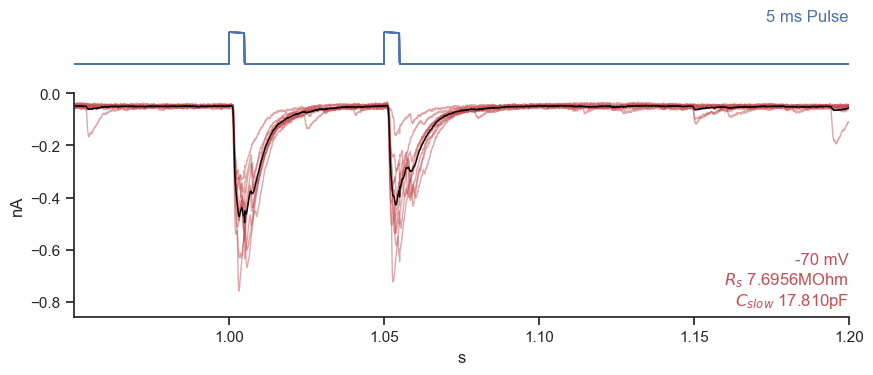

In [27]:
''' test for autoscale '''
avgplot(twop[0], wavedata, paramdata, autoscale = [50,150], theme = theme, stim_text = "5 ms Pulse")

In [28]:
''' Autoscaled images generator '''

for cell in tqdm(cells, position = 0, desc = 'Cells'):

    wave_dir = master+"/"+day+"/"+cellprefix+cell+"/"+cellprefix+cell+"_Waves"
    asc_dir  = master+"/"+day+"/"+cellprefix+cell+"/"+cellprefix+cell+".asc"
    save_dir = master+"/"+day+"/"+cellprefix+cell+"/scaled_imgs/"
    try:
       os.mkdir(save_dir[:-1])
    except FileExistsError:
       pass
    
    
    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wave_dir):
        waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData']
    wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
    
    freq = 50 #per ms (50 KHz)

    rawdata = pd.read_csv(asc_dir, encoding= 'unicode_escape',
                          names =  ["Header", "Recording Mode","Amplifier","Data Kind","Time Offset","Y-unit","X-unit","X-interval","X-start","Y-Offset","Y-range","Holding","Pipette Resistance","Seal Resistance","C-slow","R-series","Rs-value","Leak Comp.","M-conductance"])
    #keeps only rows with trace data, with only header, cslow and rseries columns
    paramdata = rawdata.loc[rawdata["Header"].str.contains('TRACE')][["Header","Holding","C-slow","R-series"]]
    paramdata["Header"] = paramdata["Header"].str.replace("TRACE_","") #remotes trace_ text
    paramdata["Header"] = paramdata["Header"].str.strip() # removes whitespaces that make indexing hell
    paramdata["Holding"] = paramdata["Holding"].str.strip() # removes whitespaces from holding
    paramdata["Holding"] = paramdata["Holding"].str.partition(".")[0] # only absolute value of holding
    paramdata["C-slow"] = paramdata["C-slow"].str.strip() # removes whitespaces from cslow
    paramdata["R-series"] = paramdata["R-series"].str.strip() # removes whitespaces from rs
    paramdata.set_index("Header", inplace = True) # replaces indexes with header eliminating slicing issue
    
    twop, onep, tr20, unassigned = protocolID(wavedata)
    
    for i in range(len(twop)):
        avgplot(twop[i], wavedata, paramdata, autoscale = autoscale, stim_text = stim_text, theme = theme, dims = dims)
        plt.savefig(save_dir+"TwoP_"+str(i)+".svg", dpi = dpi, bbox_inches = 'tight')
        plt.savefig(save_dir+"TwoP_"+str(i)+".png", dpi = dpi, bbox_inches = 'tight')
        plt.close()
    
    for i in range(len(onep)):
        avgplot(onep[i], wavedata, paramdata, autoscale = autoscale, stim_text = stim_text, theme = theme, dims = dims)
        plt.savefig(save_dir+"oneP_"+str(i)+".svg", dpi = dpi, bbox_inches = 'tight')
        plt.savefig(save_dir+"oneP_"+str(i)+".png", dpi = dpi, bbox_inches = 'tight')
        plt.close() 
    
    #print("Done with cell "+cell)
    
#print("All done and dusted!")

Cells: 100%|█████████████████████████████████████████████████████████████████████████████| 6/6 [00:48<00:00,  8.03s/it]


## CC imgs

In [29]:
''' CC BnW images generator '''

for cell in tqdm(cells):

    wave_dir = master+"/"+day+"/"+cellprefix+cell+"/"+cellprefix+cell+"_Waves"
    asc_dir  = master+"/"+day+"/"+cellprefix+cell+"/"+cellprefix+cell+".asc"
    save_dir = master+"/"+day+"/"+cellprefix+cell+"/CC_imgs/"
    try:
       os.mkdir(save_dir[:-1])
    except FileExistsError:
       pass
    
    
    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wave_dir):
        waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData']
    wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
    
    freq = 50 #per ms (50 KHz)

    rawdata = pd.read_csv(asc_dir, encoding= 'unicode_escape',
                          names =  ["Header", "Recording Mode","Amplifier","Data Kind","Time Offset","Y-unit","X-unit","X-interval","X-start","Y-Offset","Y-range","Holding","Pipette Resistance","Seal Resistance","C-slow","R-series","Rs-value","Leak Comp.","M-conductance"])
    #keeps only rows with trace data, with only header, cslow and rseries columns
    paramdata = rawdata.loc[rawdata["Header"].str.contains('TRACE')][["Header","Holding","C-slow","R-series"]]
    paramdata["Header"] = paramdata["Header"].str.replace("TRACE_","") #remotes trace_ text
    paramdata["Header"] = paramdata["Header"].str.strip() # removes whitespaces that make indexing hell
    paramdata["Holding"] = paramdata["Holding"].str.strip() # removes whitespaces from holding
    paramdata["Holding"] = paramdata["Holding"].str.partition(".")[0] # only absolute value of holding
    paramdata["C-slow"] = paramdata["C-slow"].str.strip() # removes whitespaces from cslow
    paramdata["R-series"] = paramdata["R-series"].str.strip() # removes whitespaces from rs
    paramdata.set_index("Header", inplace = True) # replaces indexes with header eliminating slicing issue
    
    twop, onep, tr20, unassigned = protocolID(wavedata)
    
    for i in range(len(unassigned)):
        alpha = 1
        sns.set_theme(style="white", palette = 'deep')
        freq = 50
        time = 0.001*np.arange(0,wavedata[unassigned[0]][wavedata[unassigned[0]].columns[0]].shape[0])/freq

        plt.plot(time, wavedata[unassigned[i]], color = 'black', linewidth = 0.2)

        sns.despine(top=True, right=True, left=True, bottom=True)
        plt.gca().spines["left"].set_visible(True)
        plt.gca().spines["bottom"].set_visible(True)
        plt.gca().tick_params(bottom=True, left=True)
        plt.ylabel("mV")
        plt.xlabel("Time (s)")
        plt.gcf().set_size_inches(dims)  
        
        plt.savefig(save_dir+"CC_"+str(i)+".svg", dpi = dpi, bbox_inches = 'tight')
        plt.savefig(save_dir+"CC_"+str(i)+".png", dpi = dpi, bbox_inches = 'tight')
        plt.close()
    
    #print("Done with cell "+cell)
    
#print("All done and dusted!")

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:27<00:00,  4.57s/it]


## testing CC plot

functionally, unassigned == CC


In [74]:
cells = ['F']

In [75]:
for cell in cells:
    save_dir = master+"/"+day+"/"+cellprefix+cell+"/"
    wave_dir = master+"/"+day+"/"+cellprefix+cell+"/"+cellprefix+cell+"_Waves"
    asc_dir  = master+"/"+day+"/"+cellprefix+cell+"/"+cellprefix+cell+".asc"
    save_dir = master+"/"+day+"/"+cellprefix+cell+"/raw_imgs/"
    try:
       os.mkdir(save_dir[:-1])
    except FileExistsError:
       pass
    
    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wave_dir):
        waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData']
    wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
    
    freq = 50 #per ms (50 KHz)

    rawdata = pd.read_csv(asc_dir, encoding= 'unicode_escape',
                          names =  ["Header", "Recording Mode","Amplifier","Data Kind","Time Offset","Y-unit","X-unit","X-interval","X-start","Y-Offset","Y-range","Holding","Pipette Resistance","Seal Resistance","C-slow","R-series","Rs-value","Leak Comp.","M-conductance"])
    #keeps only rows with trace data, with only header, cslow and rseries columns
    paramdata = rawdata.loc[rawdata["Header"].str.contains('TRACE')][["Header","Holding","C-slow","R-series"]]
    paramdata["Header"] = paramdata["Header"].str.replace("TRACE_","") #remotes trace_ text
    paramdata["Header"] = paramdata["Header"].str.strip() # removes whitespaces that make indexing hell
    paramdata["Holding"] = paramdata["Holding"].str.strip() # removes whitespaces from holding
    paramdata["Holding"] = paramdata["Holding"].str.partition(".")[0] # only absolute value of holding
    paramdata["C-slow"] = paramdata["C-slow"].str.strip() # removes whitespaces from cslow
    paramdata["R-series"] = paramdata["R-series"].str.strip() # removes whitespaces from rs
    paramdata.set_index("Header", inplace = True) # replaces indexes with header eliminating slicing issue
    
    twop, onep, tr20, unassigned = protocolID(wavedata)

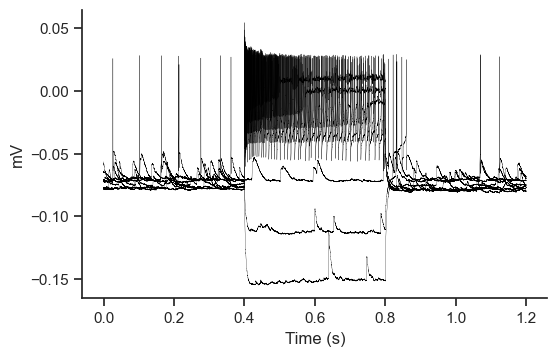

In [76]:
'''black and white version'''

alpha = 1
sns.set_theme(style="white", palette = 'deep')
freq = 50
time = 0.001*np.arange(0,wavedata[unassigned[0]][wavedata[unassigned[0]].columns[0]].shape[0])/freq

i = 0

plt.plot(time, wavedata[unassigned[i]], color = 'black', linewidth = 0.2)
#for j in range(len(wavedata[unassigned[i]].columns)):
    #alpha += 0.04
    #plt.plot(time, wavedata[unassigned[j]][wavedata[unassigned[j]].columns[j]], color = 'black', linewidth = 0.15, alpha = alpha)

    
sns.despine(top=True, right=True, left=True, bottom=True)
plt.gca().spines["left"].set_visible(True)
plt.gca().spines["bottom"].set_visible(True)
plt.gca().tick_params(bottom=True, left=True)
plt.ylabel("mV")
plt.xlabel("Time (s)")
plt.gcf().set_size_inches(dims)   

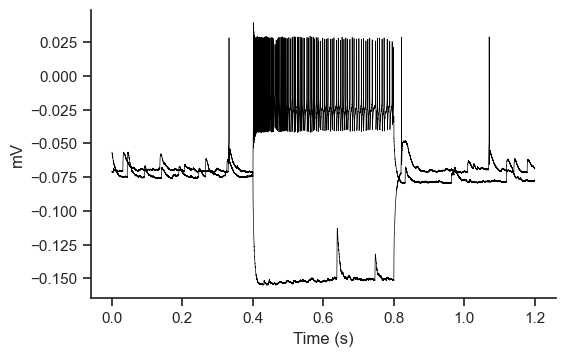

In [83]:
i = 0
n = 4
plt.plot(time, wavedata[unassigned[i]][wavedata[unassigned[i]].columns[0]], color = 'black', linewidth = 0.5)
plt.plot(time, wavedata[unassigned[i]][wavedata[unassigned[i]].columns[n]], color = 'black', linewidth = 0.5)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.gca().spines["left"].set_visible(True)
plt.gca().spines["bottom"].set_visible(True)
plt.gca().tick_params(bottom=True, left=True)
plt.ylabel("mV")
plt.xlabel("Time (s)")
plt.gcf().set_size_inches(dims)  

plt.savefig("CC_dump.svg", dpi = 600, bbox_inches = 'tight')

In [ ]:
#### ''' colorful version '''

clrs = ['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red','black']
#['r','b','g','y','c','m','k', 'purple']
sns.set_theme(style="white", palette = 'deep')
freq = 50
time = 0.001*np.arange(0,wavedata[unassigned[0]][wavedata[unassigned[0]].columns[0]].shape[0])/freq

for i in range(len(wavedata[unassigned[0]].columns)):
    plt.plot(time, wavedata[unassigned[0]][wavedata[unassigned[0]].columns[i]], color = clrs[i], linewidth = 0.25)
plt.gcf().set_size_inches(dims)    
sns.despine(top=True, right=True, left=True, bottom=True)
plt.gca().spines["left"].set_visible(True)
plt.gca().spines["bottom"].set_visible(True)
plt.gca().tick_params(bottom=True, left=True)
plt.ylabel("mV")
plt.xlabel("Time (s)")

In [21]:
''' CC BnW images generator '''

for cell in cells:

    wave_dir = master+"/"+day+"/"+cellprefix+cell+"/"+cellprefix+cell+"_Waves"
    asc_dir  = master+"/"+day+"/"+cellprefix+cell+"/"+cellprefix+cell+".asc"
    save_dir = master+"/"+day+"/"+cellprefix+cell+"/CC_imgs/"
    try:
       os.mkdir(save_dir[:-1])
    except FileExistsError:
       pass
    
    
    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wave_dir):
        waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData']
    wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
    
    freq = 50 #per ms (50 KHz)

    rawdata = pd.read_csv(asc_dir, encoding= 'unicode_escape',
                          names =  ["Header", "Recording Mode","Amplifier","Data Kind","Time Offset","Y-unit","X-unit","X-interval","X-start","Y-Offset","Y-range","Holding","Pipette Resistance","Seal Resistance","C-slow","R-series","Rs-value","Leak Comp.","M-conductance"])
    #keeps only rows with trace data, with only header, cslow and rseries columns
    paramdata = rawdata.loc[rawdata["Header"].str.contains('TRACE')][["Header","Holding","C-slow","R-series"]]
    paramdata["Header"] = paramdata["Header"].str.replace("TRACE_","") #remotes trace_ text
    paramdata["Header"] = paramdata["Header"].str.strip() # removes whitespaces that make indexing hell
    paramdata["Holding"] = paramdata["Holding"].str.strip() # removes whitespaces from holding
    paramdata["Holding"] = paramdata["Holding"].str.partition(".")[0] # only absolute value of holding
    paramdata["C-slow"] = paramdata["C-slow"].str.strip() # removes whitespaces from cslow
    paramdata["R-series"] = paramdata["R-series"].str.strip() # removes whitespaces from rs
    paramdata.set_index("Header", inplace = True) # replaces indexes with header eliminating slicing issue
    
    twop, onep, tr20, unassigned = protocolID(wavedata)
    
    for i in range(len(unassigned)):
        alpha = 1
        sns.set_theme(style="white", palette = 'deep')
        freq = 50
        time = 0.001*np.arange(0,wavedata[unassigned[0]][wavedata[unassigned[0]].columns[0]].shape[0])/freq

        plt.plot(time, wavedata[unassigned[i]], color = 'black', linewidth = 0.2)

        sns.despine(top=True, right=True, left=True, bottom=True)
        plt.gca().spines["left"].set_visible(True)
        plt.gca().spines["bottom"].set_visible(True)
        plt.gca().tick_params(bottom=True, left=True)
        plt.ylabel("mV")
        plt.xlabel("Time (s)")
        plt.gcf().set_size_inches(dims)  
        
        plt.savefig(save_dir+"CC_"+str(i)+".svg", dpi = dpi, bbox_inches = 'tight')
        plt.savefig(save_dir+"CC_"+str(i)+".png", dpi = dpi, bbox_inches = 'tight')
        plt.close()
    
    print("Done with cell "+cell)
    
print("All done and dusted!")

Done with cell B
All done and dusted!
